***

<font color='green'>

# Project Solution: Unsupervised Learning (Clustering)
### Filename: car-mpg.csv
### File consists of mpg for city-cycle fuel consumption in mpg, and other attributes (multivalued discrete and continuous)  
### Purpose: Predict city-cycle fuel consumption in mpg
### Learning outcome: EDA, Clustering, Supervised Learning
***
***
*Prepared by: Sauvik De*

*Date: October 18, 2020*
    
</font>

***

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist, pdist
from scipy.stats import zscore
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures

In [2]:
# Read in data and store it in variable cars
cars = pd.read_csv('car-mpg.csv', sep=',', header=0)

### Exploratory Data Analysis

In [3]:
print(f'The shape of the dataframe is {cars.shape}')
print('\nFirst few rows of the dataframe:')
cars.head()

The shape of the dataframe is (398, 9)

First few rows of the dataframe:


,mpg,cyl,disp,hp,wt,acc,yr,origin,car_name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [4]:
# Check columns and their datatypes
print("\nThere don't seem to be any missing values. Columns in the dataframe are integer, float or object type.\
 Variables car_name and hp are object types. Notably data for hp is expected to be numeric and hence needs investigation.\n")
cars.info()


There don't seem to be any missing values. Columns in the dataframe are integer, float or object type. Variables car_name and hp are object types. Notably data for hp is expected to be numeric and hence needs investigation.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
mpg         398 non-null float64
cyl         398 non-null int64
disp        398 non-null float64
hp          398 non-null object
wt          398 non-null int64
acc         398 non-null float64
yr          398 non-null int64
origin      398 non-null int64
car_name    398 non-null object
dtypes: float64(3), int64(4), object(2)
memory usage: 28.1+ KB


In [5]:
# Looking at unique values of hp variable
print("\nThere is a '?' among hp values and hence we can either impute or delete the records for those cases with hp = '?'")
cars['hp'].unique()


There is a '?' among hp values and hence we can either impute or delete the records for those cases with hp = '?'


array(['130', '165', '150', '140', '198', '220', '215', '225', '190',
       '170', '160', '95', '97', '85', '88', '46', '87', '90', '113',
       '200', '210', '193', '?', '100', '105', '175', '153', '180', '110',
       '72', '86', '70', '76', '65', '69', '60', '80', '54', '208', '155',
       '112', '92', '145', '137', '158', '167', '94', '107', '230', '49',
       '75', '91', '122', '67', '83', '78', '52', '61', '93', '148',
       '129', '96', '71', '98', '115', '53', '81', '79', '120', '152',
       '102', '108', '68', '58', '149', '89', '63', '48', '66', '139',
       '103', '125', '133', '138', '135', '142', '77', '62', '132', '84',
       '64', '74', '116', '82'], dtype=object)

In [6]:
print(f"\nThere are {(cars['hp']=='?').sum()} records with hp = '?' out of total {cars.shape[0]} records.")
cars.loc[cars['hp']=='?',:]


There are 6 records with hp = '?' out of total 398 records.


,mpg,cyl,disp,hp,wt,acc,yr,origin,car_name
32,25.0,4,98.0,?,2046,19.0,71,1,ford pinto
126,21.0,6,200.0,?,2875,17.0,74,1,ford maverick
330,40.9,4,85.0,?,1835,17.3,80,2,renault lecar deluxe
336,23.6,4,140.0,?,2905,14.3,80,1,ford mustang cobra
354,34.5,4,100.0,?,2320,15.8,81,2,renault 18i
374,23.0,4,151.0,?,3035,20.5,82,1,amc concord dl


In [7]:
cars['hp'].replace('?', np.nan, inplace=True)
cars['hp'] = cars['hp'].astype(float)

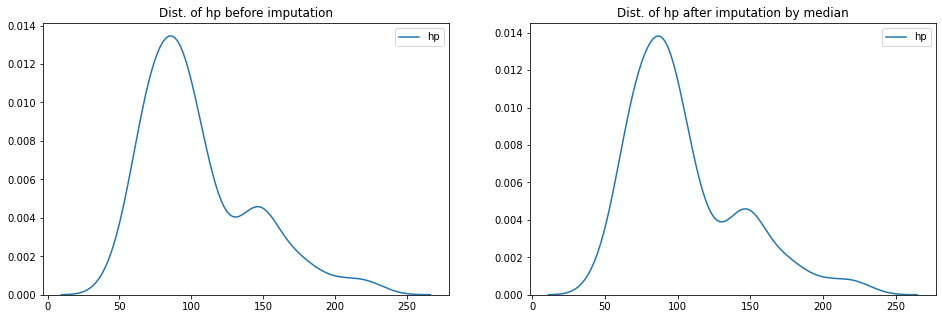

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(16,5))
_ = sns.kdeplot(cars['hp'], ax=ax[0]).set_title('Dist. of hp before imputation')
_ = sns.kdeplot(cars['hp'].replace(np.nan, cars['hp'].median(), inplace=False), ax=ax[1]).\
set_title('Dist. of hp after imputation by median')

In [9]:
# No major change in the distribution of hp due to median imputation
# Impute the missing values in hp column by median values
cars['hp'].replace(np.nan, cars['hp'].median(), inplace=True)

In [10]:
# Check if there are any duplicated records across all the features
print('Number of duplicated rows = %d' % (cars.duplicated().sum()))
print("There are no duplicated entries - so let's move on.")

Number of duplicated rows = 0
There are no duplicated entries - so let's move on.


In [11]:
# Look at the frequency distribution for categorical / multi-valued discrete columns
print(f"\nThere are {cars['car_name'].nunique()} unique car names in the dataset with max frequency for car names being 6.")
print("This may require some feature engineering to make it useful for modeling consideration.")
print(cars['car_name'].value_counts())
print('\nFrequency distribution for Cylinder count (cyl):')
print(cars['cyl'].value_counts())
print('\nFrequency distribution for Model year (yr):')
print(cars['yr'].value_counts())
print('\nFrequency distribution for Origin (origin):')
print(cars['origin'].value_counts())


There are 305 unique car names in the dataset with max frequency for car names being 6.
This may require some feature engineering to make it useful for modeling consideration.
ford pinto            6
amc matador           5
toyota corolla        5
ford maverick         5
chevrolet chevette    4
                     ..
vw pickup             1
chevrolet woody       1
mercury lynx l        1
peugeot 504 (sw)      1
mercedes-benz 240d    1
Name: car_name, Length: 305, dtype: int64

Frequency distribution for Cylinder count (cyl):
4    204
8    103
6     84
3      4
5      3
Name: cyl, dtype: int64

Frequency distribution for Model year (yr):
73    40
78    36
76    34
82    31
75    30
81    29
80    29
79    29
70    29
77    28
72    28
71    28
74    27
Name: yr, dtype: int64

Frequency distribution for Origin (origin):
1    249
3     79
2     70
Name: origin, dtype: int64


In [12]:
# Look at the descriptive statistics for individual columns
cars.describe()

,mpg,cyl,disp,hp,wt,acc,yr,origin
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.304020,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,38.222625,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,76.000000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,125.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


#### Comments
1. The no. of cylinders (cyl) in cars takes on values 3,4,5,6 and 8, with 4 being the most common no.of cylinders among cars.
2. The car-maker (origin) takes values only 1,2 and 3, with 1 being the most common origin code from where cars are manufactured.
3. disp, hp and wt seem to have a right skewed distribution with (Q3 - median) being higher than (median - Q1). Also mean is higher compared to median.
4. acc and yr seem symmetrically disrtibuted.
5. wt variable has a different scale vs others.

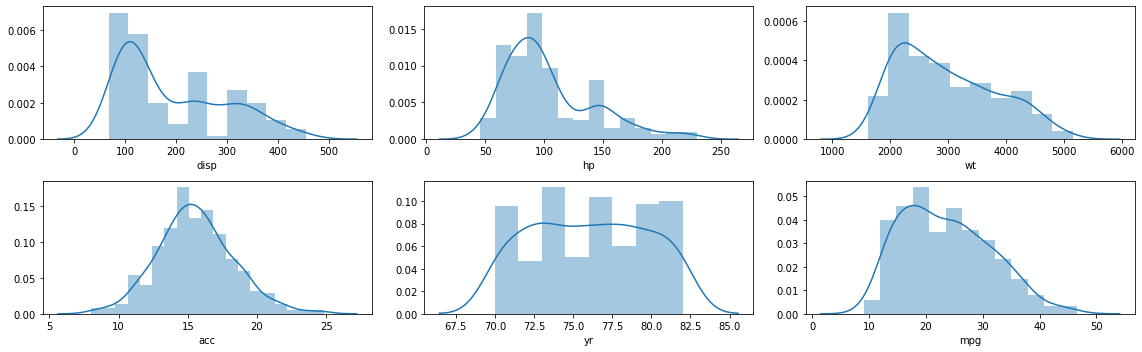

In [13]:
# Univariate Analysis
# Let's look at the histograms for checking distribution of numerical columns
fig, ax = plt.subplots(2, 3, figsize=(16,5))
sns.distplot(cars['disp'], ax=ax[0,0])
sns.distplot(cars['hp'], ax=ax[0,1])
sns.distplot(cars['wt'], ax=ax[0,2])
sns.distplot(cars['acc'], ax=ax[1,0])
sns.distplot(cars['yr'], ax=ax[1,1])
sns.distplot(cars['mpg'], ax=ax[1,2])
plt.tight_layout()

#### Comments

1. Similar findings as before. disp, hp, wt seem to be right-skewed.
2. acc and yr seem symmetrically distributed.
3. Distribution of disp, hp, wt, yr seem to have a few peaks in the data potentially indicating multiple groups in the data.


cyl count of 4 is the most common among cars followed by cars with 8 and 6 cylinders respectively.
Most of the cars are from origin 1, followed by origin 3 and origin 2.


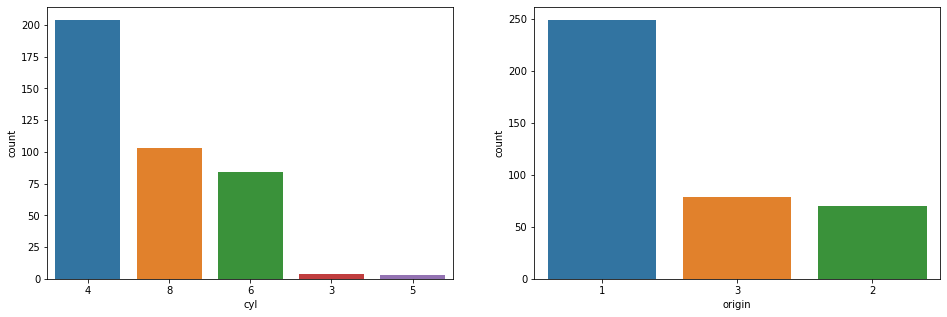

In [14]:
print('\ncyl count of 4 is the most common among cars followed by cars with 8 and 6 cylinders respectively.')
print('Most of the cars are from origin 1, followed by origin 3 and origin 2.')
fig, ax = plt.subplots(1, 2, figsize=(16,5))
_ = sns.countplot(cars['cyl'], order=cars['cyl'].value_counts().index, ax=ax[0])
_ = sns.countplot(cars['origin'], order=cars['origin'].value_counts().index, ax=ax[1])


Observations from correlation heatmap:
1. Presence of high multicollinearity among the feature variables.
2. cyl, disp, hp and wt are highly positively correlated between each other; and highly negatively correlated with mpg.
3. cyl, disp, hp and wt are all negatively correlated with both acc and yr


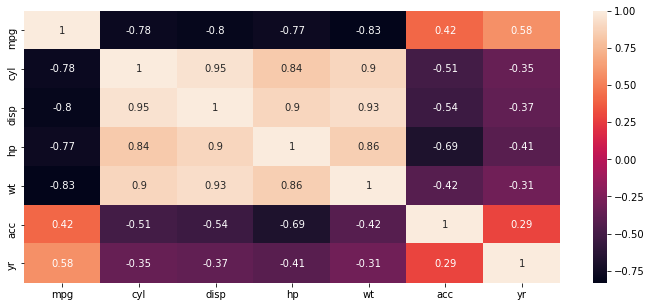

In [15]:
# Look at correlation
print('\nObservations from correlation heatmap:')
print('1. Presence of high multicollinearity among the feature variables.')
print('2. cyl, disp, hp and wt are highly positively correlated between each other; and highly negatively correlated with mpg.')
print('3. cyl, disp, hp and wt are all negatively correlated with both acc and yr')

plt.figure(figsize=(12,5))
_ = sns.heatmap(cars.drop(columns=['car_name', 'origin'], axis=1).corr(), annot=True)

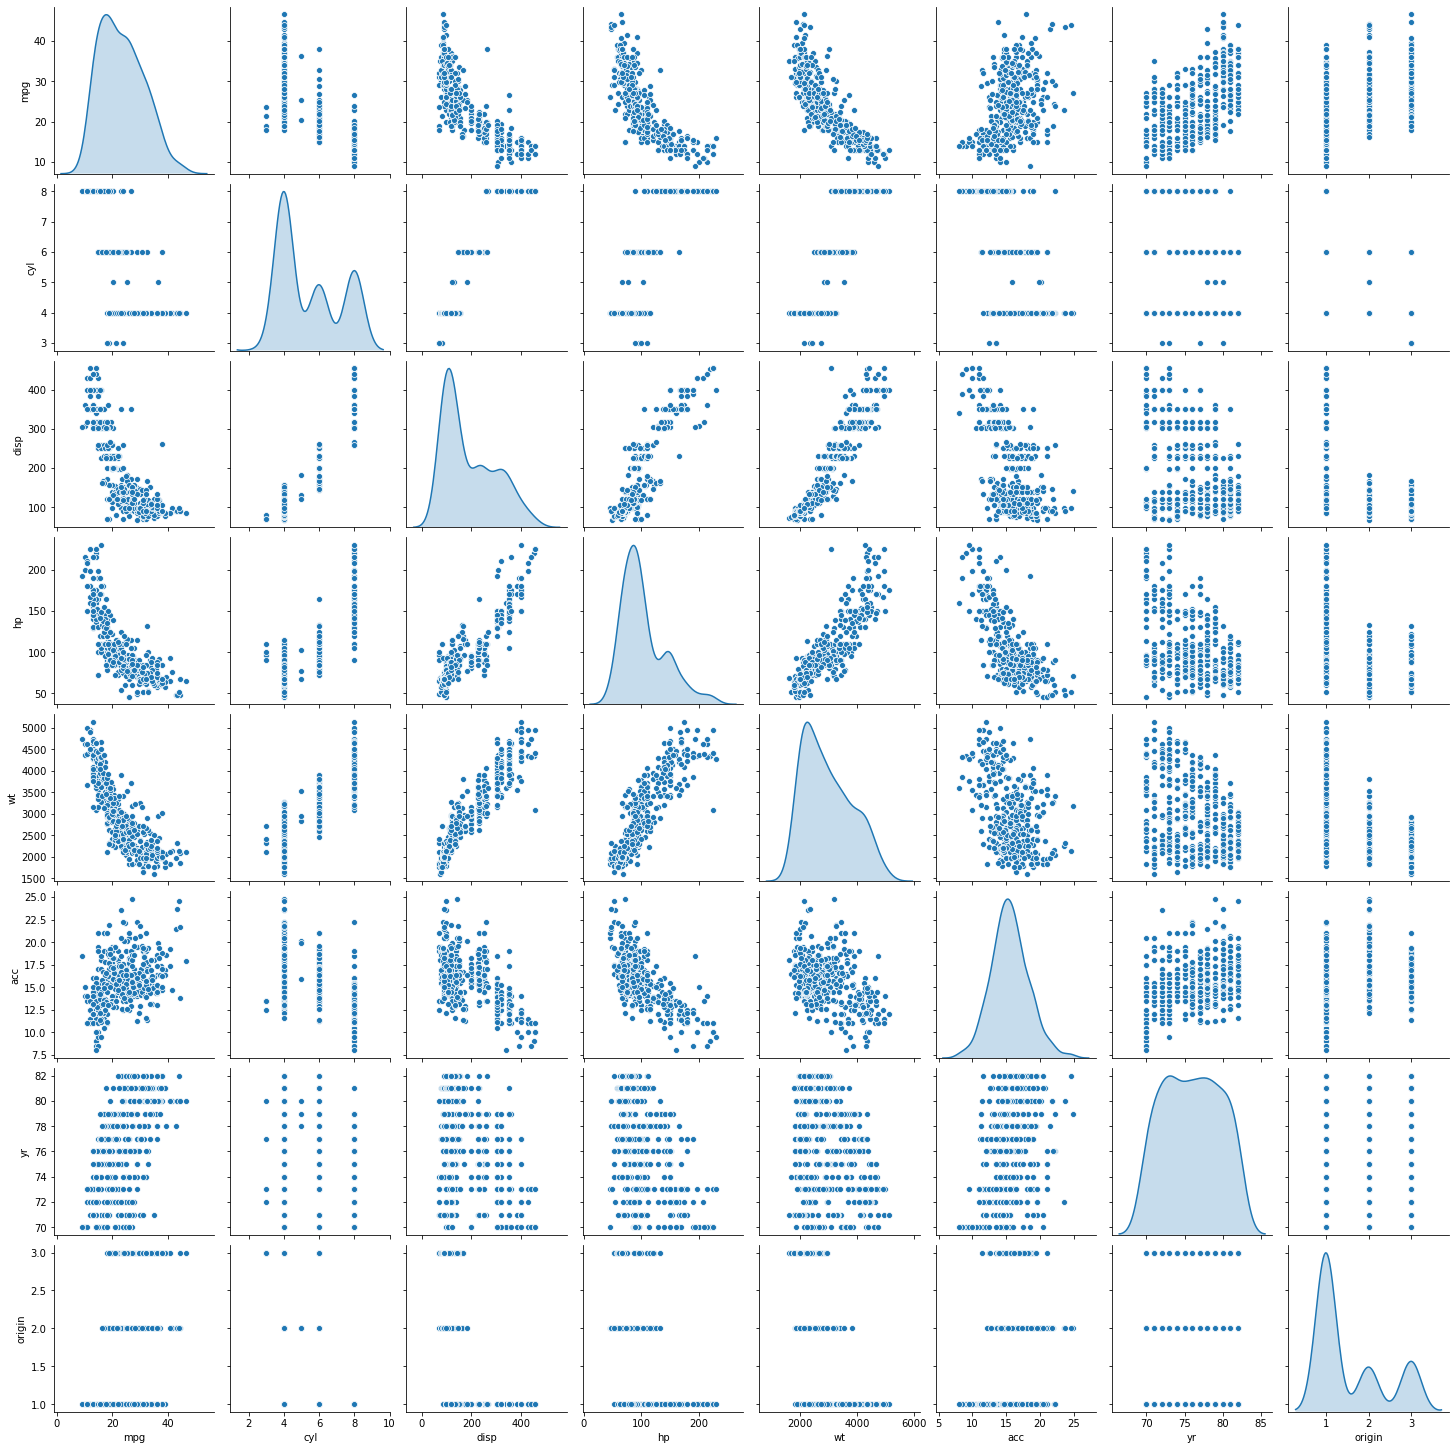

In [16]:
# Bivariate analysis
# Look at pairplot
# _ = sns.pairplot(cars.drop(columns='car_name', axis=1), diag_kind='kde', diag_kws={'bw':0.2}, hue='origin')
_ = sns.pairplot(cars.drop(columns='car_name', axis=1), diag_kind='kde')

#### Few observations / insights from above pairplot:

1. As noted earlier, no. of cylinders (cyl) and origin of car (origin) are having very few catetgories. So we find some natural groupings in their distribution. Notably there are three groups evident for these two features.
2. It will be more interesting if we could find hidden clusters looking at the distribution of other continuous numerical features. The distribution of disp and hp also do have three peaks confirming the likely groupings of at least three.
3. wt and yr have two distinct peaks indicating presence of at least two groups from direction of each of those dimensions.
4. mpg is a target variable which also shows presence of 2-3 groupings.
5. cyl, disp, hp and wt are linearly related to each other in the positive direction. This intuitively makes sense.
5. cyl, disp, hp and wt are all linearly related with both acc and yr in the negative direction.
6. cyl, disp, hp and wt are all linearly related with target/dependent variable mpg in the negative direction.
7. Both yr and acc are linearly related with target variable mpg in the positive direction.
8. Origin value of 1 is associated with low mpg, higher no. of cylinders (cyl), higher dispersion (disp), higher hp and higher weight (wt), and lower acceleration (acc). Intuitively, origin = 1 may represent maker of heavy car. In similar way, origin = 3 may represent maker of light car, while origin = 2 may represent maker of medium sized car.


Similar findings as earlier. Variables hp and acc have a few minor outliers.


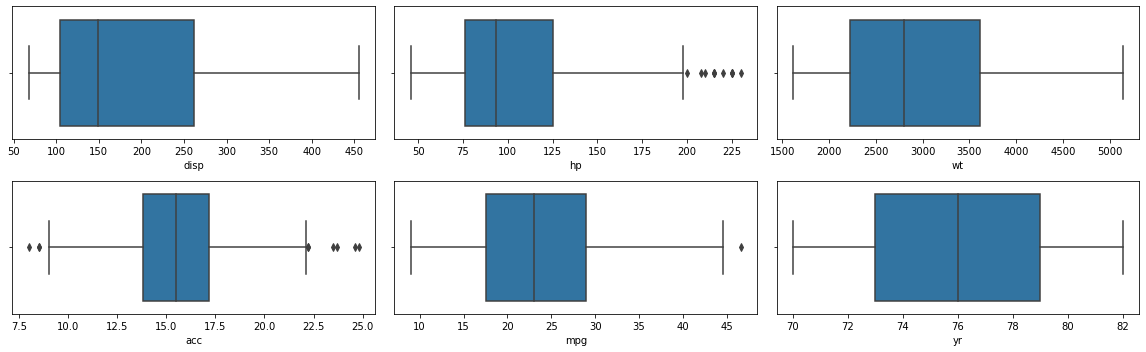

In [17]:
# Let's look at the boxplot for checking any major outlier in numerical columns
print('\nSimilar findings as earlier. Variables hp and acc have a few minor outliers.')
fig, ax = plt.subplots(2, 3, figsize=(16,5))
sns.boxplot(cars['disp'], ax=ax[0,0])
sns.boxplot(cars['hp'], ax=ax[0,1])
sns.boxplot(cars['wt'], ax=ax[0,2])
sns.boxplot(cars['acc'], ax=ax[1,0])
sns.boxplot(cars['mpg'], ax=ax[1,1])
sns.boxplot(cars['yr'], ax=ax[1,2])
plt.tight_layout()

In [18]:
def check_outliers(x):
    uw = x.quantile(q=0.75) + 1.5 * (x.quantile(q=0.75) - x.quantile(q=0.25))
    lw = x.quantile(q=0.25) - 1.5 * (x.quantile(q=0.75) - x.quantile(q=0.25))
    return({'Outliers on higher side': x[x>uw], 'Outliers on lower side': x[x<lw], 'UW point': uw, 'LW point': lw})

In [19]:
print('\nacc outliers ouside upper or lower whisker points:')
print(check_outliers(cars['acc'])['Outliers on higher side'])
print(check_outliers(cars['acc'])['Outliers on lower side'])

print('\nhp outliers outside upper whisker point:')
print(check_outliers(cars['hp'])['Outliers on higher side'])


acc outliers ouside upper or lower whisker points:
59     23.5
195    22.2
299    24.8
300    22.2
326    23.7
394    24.6
Name: acc, dtype: float64
7     8.5
9     8.5
11    8.0
Name: acc, dtype: float64

hp outliers outside upper whisker point:
6      220.0
7      215.0
8      225.0
13     225.0
25     215.0
26     200.0
27     210.0
67     208.0
94     215.0
95     225.0
116    230.0
Name: hp, dtype: float64



1. We don't use any outlier treatmant for acc variable as the distribution looks very symmetric and datapoints beyond upper/lower whisker points don't seem like 'real' outliers.
2. We try log transformation on hp variable to transform it from right-skewed distribution into a 'well-behaved' distribution.

hp variable skewness: Before log transformation = 1.1062242930872614
hp variables skewness: After log transformation = 0.3793855180691719


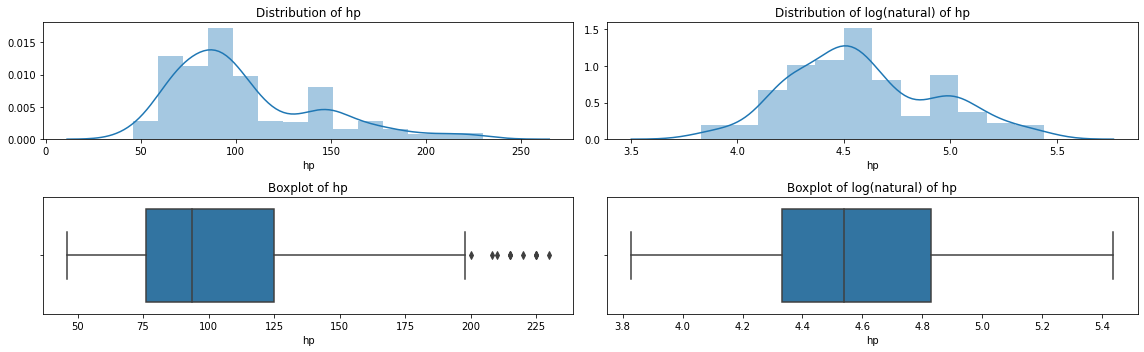

In [20]:
# Outlier handling strategy
print("\n1. We don't use any outlier treatmant for acc variable as the distribution looks very symmetric\
 and datapoints beyond upper/lower whisker points don't seem like 'real' outliers.")
print("2. We try log transformation on hp variable to transform it from right-skewed distribution into a 'well-behaved' distribution.")

print(f"\nhp variable skewness: Before log transformation = {cars['hp'].skew()}")
print(f"hp variables skewness: After log transformation = {np.log(cars['hp']).skew()}")

fig, ax = plt.subplots(2, 2, figsize=(16,5))
_ = sns.distplot(cars['hp'], ax=ax[0,0]).set_title('Distribution of hp')
_ = sns.distplot(np.log(cars['hp']), ax=ax[0,1]).set_title('Distribution of log(natural) of hp')
_ = sns.boxplot(cars['hp'], ax=ax[1,0]).set_title('Boxplot of hp')
_ = sns.boxplot(np.log(cars['hp']), ax=ax[1,1]).set_title('Boxplot of log(natural) of hp')
plt.tight_layout()

### Feature engineering

In [21]:
# Transform hp variable into a well-behaved / more symmetric distribution
cars['hp'] = np.log(cars['hp'])

In [22]:
# segregate feature and response variables
y = cars['mpg']

# car_name being a nominal variable, we can drop this for the time being from feature set
# Also mpg being target variable, we remove it from feature dataset
X = cars.drop(columns=['mpg','car_name'], axis=1, inplace=False)

In [23]:
# Distribution of individual features revealed there may be groupings in the dataset
# So we may want to look for any hidden clusters in the dataset before we try to predict mpg
# For clustering algorithm (for e.g. distance based K-Means algo),
# it is important to standardize numerical features to give equal weight to all the features for distance calc

X_scaled = X.apply(zscore)

### Cluster Analysis

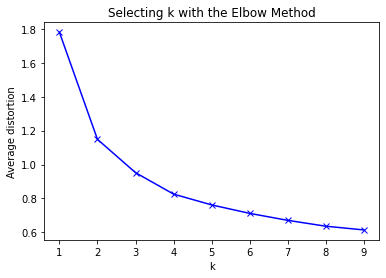

In [24]:
# Looking at the distribution of individual features we found there may be 2 to 3 groupings in the dataset
# There may be more clusters hidden behind another dimension
# so we can use 3 to 6 (2*3) as the number of groupings as a starting point in K-Means clustering settings
# For better visibility, I tried the range of K (no. of potential clusters) from 1 to 9

# Further we can use elbow method to determine the numeber of clusters we may want to consider for the analysis

#**************************************************************************************************************

# As there are features which contribute to natural groupings (for e.g.: no. of cylinders (cyl), origin of car (origin)),
# we will drop these features before applying clustering algorithm.

X_sub_scaled = X_scaled.drop(columns=['cyl', 'origin', 'yr'], axis=1, inplace=False)
cols_for_clust = X_sub_scaled.columns

# Finding optimal no. of clusters
clusters = range(1,10)
meanDistortions=[]

# compute average within cluster variance for each no. of clusters (K)
for k in clusters:
    mdl = KMeans(n_clusters=k, random_state=1)
    mdl.fit(X_sub_scaled)
    prediction = mdl.predict(X_sub_scaled)
    meanDistortions.append(sum(np.min(cdist(X_sub_scaled, mdl.cluster_centers_, 'euclidean'), axis=1)) / X_sub_scaled.shape[0])

plt.plot(clusters, meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average distortion')
_ = plt.title('Selecting k with the Elbow Method')

#### Comments from K-Means clustering output:

1. From the elbow plot, the bends appear at K = 2, 3, 4. So K = 4 may be an initial choice for the no. of clusters.
2. We can try with K = 4 if we can interpret those clusters based on domain knowledge. If not, we will try with K = 3, or, K = 2

In [25]:
# Trying with K = 4 for K-Means clustering
mdl = KMeans(n_clusters=4, random_state=1)
mdl.fit(X_sub_scaled)

X_sub_scaled['KM_CLUSTER'] = mdl.predict(X_sub_scaled)

In [26]:
X_sub_scaled.groupby('KM_CLUSTER').agg('count')

,disp,hp,wt,acc
KM_CLUSTER,,,,
0,85,85,85,85
1,97,97,97,97
2,83,83,83,83
3,133,133,133,133


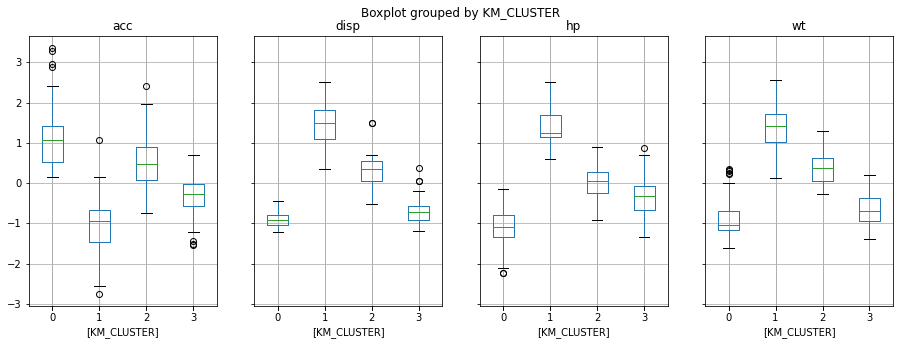

In [27]:
# Let's see visually how well the features get segregated
_ = X_sub_scaled.boxplot(by='KM_CLUSTER', layout=(1,4), figsize=(15,5))

#### Comments
1. With 4 clusters, cluster IDs 0 and 1 likely to correspond to light and heavy cars respectively.
2. Cluster IDs 2 and 3 have similar direction across all the four features (acc, disp, hp and wt) that is not quite intuitive. Hence we can cluster these two IDs into one.
3. Let's try with K = 3 now.

In [28]:
# Trying with K = 3 for K-Means clustering
mdl = KMeans(n_clusters=3, random_state=1)
mdl.fit(X_sub_scaled)

X_sub_scaled['KM_CLUSTER'] = mdl.predict(X_sub_scaled)

In [29]:
X_sub_scaled.groupby('KM_CLUSTER').agg('count')

,disp,hp,wt,acc
KM_CLUSTER,,,,
0,85,85,85,85
1,214,214,214,214
2,99,99,99,99


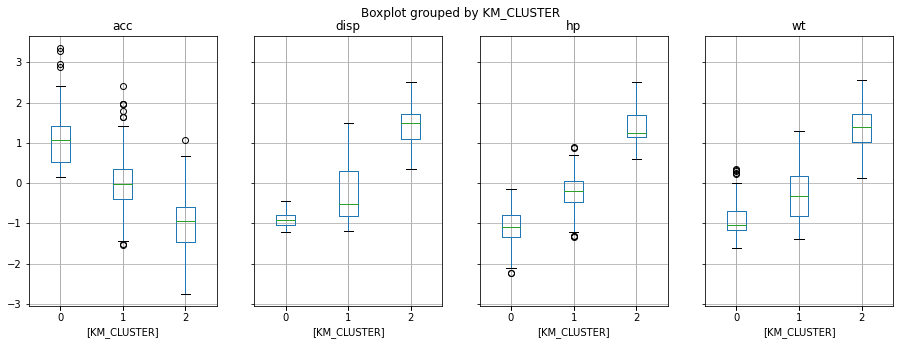

In [30]:
# Let's see visually how well the features get segregated
_ = X_sub_scaled.boxplot(by='KM_CLUSTER', layout=(1,4), figsize=(15,5))

#### Comments
1. With 3 clusters, cluster IDs 0 and 2 likely correspond to light and heavy cars respectively; while cluster ID 1 correspond to medium weight cars.
2. Since we are able to interpret the clusters with K = 3, the optimal no. of custers is 3.

#### General comments on using K-Means clustering algorithm for this dataset:
1. K-Means being flat clustering technique, sometimes it may not be able to find sub-clusters within clusters
2. One disadvantage with K-Means clustering algorithm is that it can only use Euclidean method to calculate distance. From the bi-variate scatterplot we had earlier, the spreads were elliptical in shape for a few pairs (displacement (disp), weight (wt)), (displacement (disp), horsepower (hp)). So the Euclidean method to compute distance between two datapoints may NOT be a good idea for such cases. Mahalanobis distance may be better suited for distance calculation.
3. Also the other point on K-Means algo is the initial centroids are subjective and hence that might affect the end-clusters.

In [31]:
# Let's try with Hierarchical clustering
# The advantage of hierarchical clustering over K-means clustering is 
# hierarchical clustering can find further sub-clusters within clusters in tree-like fashion (parent-child way)
# enabling finding hidden clusters in the data at a a granular level.
# While k-means clustering is flat or non-hierarchical clustering technique.

# Compute cophenetic correlation coefficient using different linkage methods of Agglomerative Hierarchical clustering
for typ in ['single', 'complete', 'average', 'ward']:
    L = linkage(X_sub_scaled[cols_for_clust], method=typ, metric='euclidean')
    c, coph_dists = cophenet(L , pdist(X_sub_scaled))
    print('Linkage:', typ, '-> cophenetic correlation =', c)

print('\nAverage linkage seems to produce max cophenetic correlation. Ward linkage is second best.')

Linkage: single -> cophenetic correlation = 0.45419003683140274
Linkage: complete -> cophenetic correlation = 0.7615062348927976
Linkage: average -> cophenetic correlation = 0.8016944195131398
Linkage: ward -> cophenetic correlation = 0.7749530008266214

Average linkage seems to produce max cophenetic correlation. Ward linkage is second best.


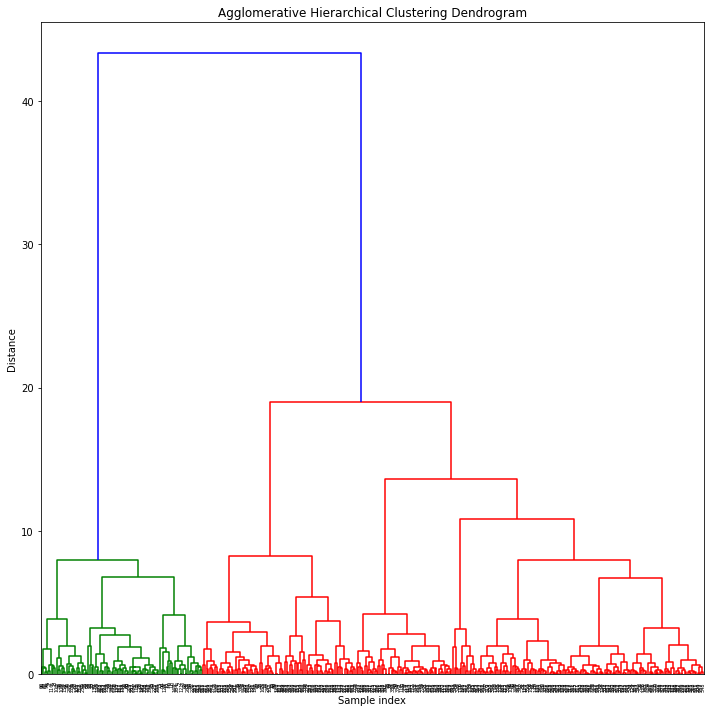

In [32]:
# Since Average linkage tends to perform well on cleanly separated globular clusters,
# and, Ward linkage tends to perform well on noisy data and based on minimizing within cluster variance,
# we use Ward linkage to construct Agglomerative Hierarchical clustering

L = linkage(X_sub_scaled[cols_for_clust], method='ward', metric='euclidean')
plt.figure(figsize=(10, 10))
plt.title('Agglomerative Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
dendrogram(L)
plt.tight_layout()

#### Comments:

Here the number of optimum clusters seem to be 3 - cutting the threshold (dendrogramic distance) just below 20.

In [33]:
mdl = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
mdl.fit(X_sub_scaled[cols_for_clust])
X_sub_scaled['AH_CLUSTER'] = mdl.labels_

In [34]:
X_sub_scaled.drop(columns='KM_CLUSTER', axis=1, inplace=False).groupby('AH_CLUSTER').agg('count')

,disp,hp,wt,acc
AH_CLUSTER,,,,
0,209,209,209,209
1,97,97,97,97
2,92,92,92,92


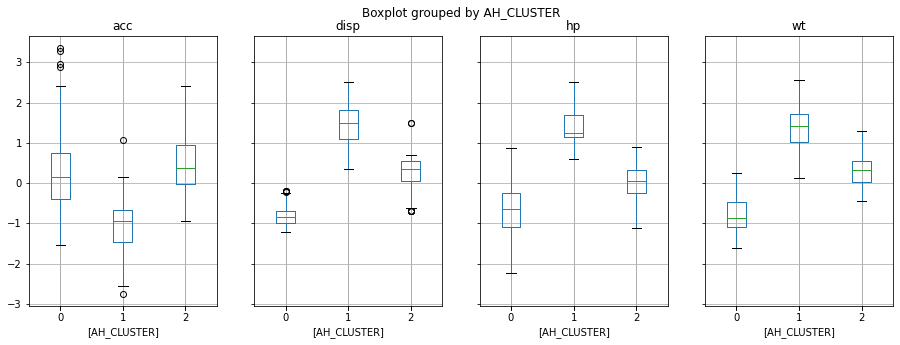

In [35]:
# Let's see visually how well the features get segregated using three clusters using Agglomerative Hierarchical clustering
_ = X_sub_scaled.drop(columns='KM_CLUSTER', axis=1, inplace=False).boxplot(by='AH_CLUSTER', layout=(1,4), figsize=(15,5))

#### Comments
1. Having three clusters makes sense here as the boxplots across clusters don't overlap for all numerical features except for acc.
2. Cluster ID 0 and 1 likely correspond to light and heavy cars respectively.

#### Comparative comments on using K-Means and Agglomerative Hierarchical clustering:

1. The difference between K-Means and Hierarchical clustering lies in their alogorithm:
   - K-Means is a flat clustering technique based on distance from initialized centroids looking at all the datapoints. So K-Means is helpful in finding 'consensus' clusters across full dataset.
   - Agglomerative Hierarchical clustering is helpful in finding embedded structures in the data. So dendrogram plot of hierarchical clustering enables insights about sub-clusters within clusters
2. K-Means clustering is dependent on providing number of clusters; while just looking at the dendreogram of agglomerative hierarchical clustering, we can make out inherent structures of 
3. Also, K-Means clustering is dependent on using initial centroids to have the end cluster results. Hierarchical clustering removes this level of subjectivity. 
4. Based on the above cluster analysis, we found presence of 3 distinct clusters in the dataset for both K-Means and Hierarchical clustering.

### Linear Regression to predict mpg

In [36]:
# Let's perform linear regression within each cluster to predict mpg

# Prepare data
X_full_scaled = X_scaled.join(X_sub_scaled[['AH_CLUSTER', 'KM_CLUSTER']])
X_full_scaled.drop(columns='origin', axis=1, inplace=True)
X_full_scaled = X_full_scaled.join(X['origin'])

# Add one-hot-encoding variables for origin
tmp = pd.get_dummies(X_full_scaled['origin'], prefix='Origin', drop_first=True)
X_final = X_full_scaled.join(tmp)
X_final.drop(columns='origin', axis=1, inplace=True)

In [37]:
def extract_coef(model, X):
    coef_key = list(X.columns)
    coef_key.insert(0, 'Intercept')
    coef_value = list(model.coef_)
    coef_value.insert(0, model.intercept_)
    return(pd.DataFrame(data=dict(zip(coef_key,coef_value)), index=['']).T)

In [38]:
# Prepare training and test data sets within each cluster using K-Means clustering
y0 = y[X_final['KM_CLUSTER'] == 0]
X0 = X_final[X_final['KM_CLUSTER'] == 0].drop(columns=['KM_CLUSTER', 'AH_CLUSTER'], axis=1, inplace=False)

y1 = y[X_final['KM_CLUSTER'] == 1]
X1 = X_final[X_final['KM_CLUSTER'] == 1].drop(columns=['KM_CLUSTER', 'AH_CLUSTER'], axis=1, inplace=False)

y2 = y[X_final['KM_CLUSTER'] == 2]
X2 = X_final[X_final['KM_CLUSTER'] == 2].drop(columns=['KM_CLUSTER', 'AH_CLUSTER'], axis=1, inplace=False)

X0_train, X0_test, y0_train, y0_test = train_test_split(X0, y0, test_size=0.3, random_state=1)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=1)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=1)

In [39]:
lr0 = LinearRegression()
lr0.fit(X0_train, y0_train)
print('\nLinear Regression on cluster 0')
print('Training size:', X0_train.shape[0], '   Test size:', X0_test.shape[0])
print('Training score:', lr0.score(X0_train, y0_train))
print('Test score:', lr0.score(X0_test, y0_test))
print('\nRegression coefficients:')
print(extract_coef(lr0, X0_train))
print('*'*75)

lr1 = LinearRegression()
lr1.fit(X1_train, y1_train)
print('\nLinear Regression on cluster 1')
print('Training size:', X1_train.shape[0], '   Test size:', X1_test.shape[0])
print('Training score:', lr1.score(X1_train, y1_train))
print('Test score:', lr1.score(X1_test, y1_test))
print('\nRegression coefficients:')
print(extract_coef(lr1, X1_train))
print('*'*75)

lr2 = LinearRegression()
lr2.fit(X2_train, y2_train)
print('\nLinear Regression on cluster 2')
print('Training size:', X2_train.shape[0], '   Test size:', X2_test.shape[0])
print('Training score:', lr2.score(X2_train, y2_train))
print('Test score:', lr2.score(X2_test, y2_test))
print('\nRegression coefficients:')
print(extract_coef(lr2, X2_train))


Linear Regression on cluster 0
Training size: 59    Test size: 26
Training score: 0.7797666038198046
Test score: 0.5282055690659238

Regression coefficients:
                    
Intercept  15.567650
cyl         1.417159
disp       -9.846720
hp         -2.363469
wt         -2.826718
acc         0.409495
yr          3.861161
Origin_2    3.135065
Origin_3    1.071665
***************************************************************************

Linear Regression on cluster 1
Training size: 149    Test size: 65
Training score: 0.7763113770895727
Test score: 0.7295264362997946

Regression coefficients:
                    
Intercept  21.958654
cyl         0.056186
disp        0.382456
hp         -1.986669
wt         -5.980857
acc        -0.855182
yr          2.622400
Origin_2    0.196974
Origin_3    0.696232
***************************************************************************

Linear Regression on cluster 2
Training size: 69    Test size: 30
Training score: 0.5188084242124139
Test sc

#### Comments:
1. The test set accuracy scores are below 60% for cluster IDs 0 (light cars) and 2 (heavy cars); while it is about 73% for cluster ID 1 indicating poor performance of linear regression within clusters made by K-Means clustering.
2. Moreover, the training dataset sizes within clusters are small to moderate leading to not 'enough' learning.

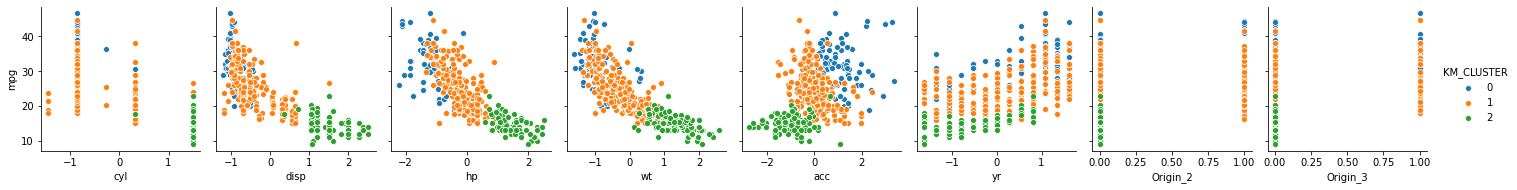

In [40]:
# Relationship between mpg and independent variables within each cluster
_ = sns.pairplot(data=X_final.join(y).drop(columns='AH_CLUSTER', axis=1, inplace=False), y_vars=['mpg'],\
                 x_vars=X_final.drop(columns=['KM_CLUSTER', 'AH_CLUSTER'], axis=1, inplace=False).columns, hue='KM_CLUSTER')

#### Comments
Within clusters, the relationship between independent and dependent variables may not very linear, except for cluster IDs 1 and 2 for hp and wt variables

In [41]:
# Prepare training and test data sets within each cluster using Agglomerative Hierarchical clustering
y0 = y[X_final['AH_CLUSTER'] == 0]
X0 = X_final[X_final['AH_CLUSTER'] == 0].drop(columns=['KM_CLUSTER', 'AH_CLUSTER'], axis=1, inplace=False)

y1 = y[X_final['AH_CLUSTER'] == 1]
X1 = X_final[X_final['AH_CLUSTER'] == 1].drop(columns=['KM_CLUSTER', 'AH_CLUSTER'], axis=1, inplace=False)

y2 = y[X_final['AH_CLUSTER'] == 2]
X2 = X_final[X_final['AH_CLUSTER'] == 2].drop(columns=['KM_CLUSTER', 'AH_CLUSTER'], axis=1, inplace=False)

X0_train, X0_test, y0_train, y0_test = train_test_split(X0, y0, test_size=0.3, random_state=1)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=1)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=1)

In [42]:
lr0 = LinearRegression()
lr0.fit(X0_train, y0_train)
print('\nLinear Regression on cluster 0')
print('Training size:', X0_train.shape[0], '   Test size:', X0_test.shape[0])
print('Training score:', lr0.score(X0_train, y0_train))
print('Test score:', lr0.score(X0_test, y0_test))
print('\nRegression coefficients:')
print(extract_coef(lr0, X0_train))
print('*'*75)

lr1 = LinearRegression()
lr1.fit(X1_train, y1_train)
print('\nLinear Regression on cluster 1')
print('Training size:', X1_train.shape[0], '   Test size:', X1_test.shape[0])
print('Training score:', lr1.score(X1_train, y1_train))
print('Test score:', lr1.score(X1_test, y1_test))
print('\nRegression coefficients:')
print(extract_coef(lr1, X1_train))
print('*'*75)

lr2 = LinearRegression()
lr2.fit(X2_train, y2_train)
print('\nLinear Regression on cluster 2')
print('Training size:', X2_train.shape[0], '   Test size:', X2_test.shape[0])
print('Training score:', lr2.score(X2_train, y2_train))
print('Test score:', lr2.score(X2_test, y2_test))
print('\nRegression coefficients:')
print(extract_coef(lr2, X2_train))


Linear Regression on cluster 0
Training size: 146    Test size: 63
Training score: 0.7091621116709297
Test score: 0.6503301700191769

Regression coefficients:
                    
Intercept  20.227377
cyl        -0.763780
disp        0.162282
hp         -0.181646
wt         -8.008728
acc         0.650145
yr          3.551692
Origin_2    1.821692
Origin_3    1.237084
***************************************************************************

Linear Regression on cluster 1
Training size: 67    Test size: 30
Training score: 0.6136333829288922
Test score: 0.4424039500431305

Regression coefficients:
                    
Intercept  19.833417
cyl        -1.077545
disp        0.003743
hp         -1.868257
wt         -1.093831
acc        -1.249734
yr          1.277264
Origin_2    0.000000
Origin_3    0.000000
***************************************************************************

Linear Regression on cluster 2
Training size: 64    Test size: 28
Training score: 0.5261982206077102
Test sc

#### Comments:
1. The test set accuracy scores are poor even for the regression models within Hierarchical clusters. Test accuracy for cluster ID 0 (light cars) and cluser ID 1 (heavy cars) are about 65% and 44% respectively.
2. Moreover, the training dataset sizes within clusters are small to moderate leading to not 'enough' learning.

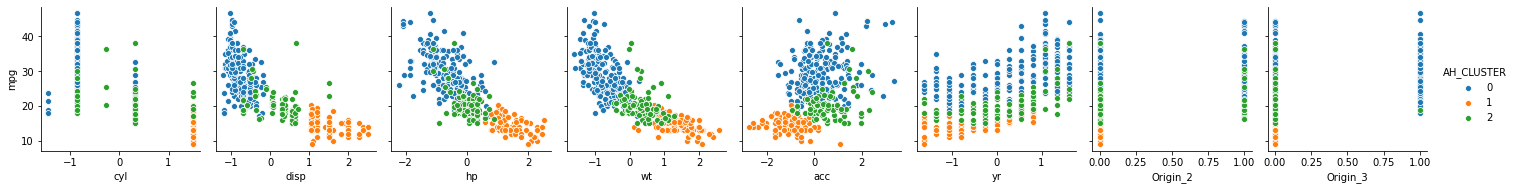

In [43]:
# Relationship between mpg and independent variables within each cluster
_ = sns.pairplot(data=X_final.join(y).drop(columns='KM_CLUSTER', axis=1, inplace=False), y_vars=['mpg'],\
                 x_vars=X_final.drop(columns=['KM_CLUSTER', 'AH_CLUSTER'], axis=1, inplace=False).columns, hue='AH_CLUSTER')

#### Comments:
Within clusters, mpg may not be linearly related to predictors except for cluster IDs 1 and 2 for hp and wt variables

In [44]:
# Different linear models within each cluster doesn't work well
# Looking at the overall trend (mpg vs other independent variables) across all datapoints, we may try one single model
# Start with linear regression

X_train, X_test, y_train, y_test = train_test_split(X_final.drop(columns=['KM_CLUSTER', 'AH_CLUSTER'], axis=1, inplace=False)\
                                                    , y, test_size=0.3, random_state=1)

lr = LinearRegression()
lr.fit(X_train, y_train)
print('\nLinear Regression')
print('Training size:', X_train.shape[0], '   Test size:', X_test.shape[0])
print('Training score:', lr.score(X_train, y_train))
print('Test score:', lr.score(X_test, y_test))
print('\nRegression coefficients:')
print(extract_coef(lr, X_train))


Linear Regression
Training size: 278    Test size: 120
Training score: 0.8305950815726162
Test score: 0.8426624378093983

Regression coefficients:
                    
Intercept  22.664854
cyl        -0.364608
disp        2.400832
hp         -3.237856
wt         -4.265012
acc        -0.770942
yr          2.929491
Origin_2    2.783571
Origin_3    2.442466


In [45]:
# There is some curvilinear relationship between mpg and other independent variables - so try polynomial features
poly = PolynomialFeatures(degree = 2, interaction_only=True)

X_poly = poly.fit_transform(X_final.drop(columns=['KM_CLUSTER', 'AH_CLUSTER'], axis=1, inplace=False))
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=1)

In [46]:
lr = LinearRegression()
lr.fit(X_train, y_train)
print('\nPolynomial Regression (of degree 2)')
print('Training size:', X_train.shape[0], '   Test size:', X_test.shape[0])
print('Training score:', lr.score(X_train, y_train))
print('Test score:', lr.score(X_test, y_test))


Polynomial Regression (of degree 2)
Training size: 278    Test size: 120
Training score: 0.9037449417457157
Test score: 0.8681246274849381


In [47]:
# Since there are lot of new features, trying with ridge regression
mdl = Ridge()
mdl.fit(X_train, y_train)
print('\nLinear Regression (with polynomial of degree 2)')
print('Training size:', X_train.shape[0], '   Test size:', X_test.shape[0])
print('Training score:', mdl.score(X_train, y_train))
print('Test score:', mdl.score(X_test, y_test))


Linear Regression (with polynomial of degree 2)
Training size: 278    Test size: 120
Training score: 0.9029730134244107
Test score: 0.8697691834297259


In [48]:
# Since there are lot of new features, trying with lasso regression as well
mdl = Lasso()
mdl.fit(X_train, y_train)
print('\nLinear Regression (with polynomial of degree 2)')
print('Training size:', X_train.shape[0], '   Test size:', X_test.shape[0])
print('Training score:', mdl.score(X_train, y_train))
print('Test score:', mdl.score(X_test, y_test))


Linear Regression (with polynomial of degree 2)
Training size: 278    Test size: 120
Training score: 0.7946853161348022
Test score: 0.8274979305576816


#### Final comments:

1. For linear regression models within clusters, the test accuracy (R-squared) didn't come out well mainly due to smaller sample size to learn the data. Larger samples would perhaps lead to better models.
2. Modelling within meaningful clusters should always be an option before trying global model for full data. Because local clusterwise model would include characteristics relevant for the particular cluster and would be expected to get better prediction.
3. In this auto-mpg dataset, the overall model did better than clusterwise models perhaps be due to not enough sample size, and deviation from linearity for individual predictors vs response within clusters
4. Looking at the overall data, we found curvilinear model did better using polynomial regression. Ridge regression also did well with polynomial features, with test set R-squared value about 87%.
5. In addition, we could also use the car names as an additional feature which we have not considered in this analysis. But this will involve splitting car name and getting brand of the cars

## <center><font color='green'>*******End of Project Solution*******</font></center>